In [1]:
##DEFINITION DER DATENSTRUKTUR


class Graph:
    def __init__(self):
        self.nodes = {}  # {node_id: (x, y)}
        self.edges = []  # [(node_id1, node_id2)]

    def add_node(self, node_id, x, y):
        self.nodes[node_id] = (x, y)

    def add_edge(self, node1, node2):
        self.edges.append((node1, node2))

In [2]:
#FUNKTION ZUM PLOTTEN DER GRAPHEN
%matplotlib inline
import matplotlib.pyplot as plt
def plot_graph(graph):
    fig, ax = plt.subplots()

    node_radius = 10

    # Zeichnen der Kanten
    for node1, node2 in graph.edges:
        x1, y1 = graph.nodes[node1]
        x2, y2 = graph.nodes[node2]
        ax.plot([x1, x2], [y1, y2], 'k-', zorder=1)  # Schwarze Linie für Kanten

    # Zeichnen der Knoten
    for node_id, (x, y) in graph.nodes.items():
        # Zeichnen Sie für jeden Knoten einen schwarzen Kreis
        circle = plt.Circle((x, y), node_radius, color='black', zorder=2)
        ax.add_artist(circle)
        # die ID innerhalb des Kreises hinzufügen
        ax.text(x, y, str(node_id), color='white', fontsize=10, ha='center', va='center', zorder=3)
    # Konfigurieren der Achsen
    ax.set_aspect('equal')
    # Passen Sie die Achsengrenzen an, um sicherzustellen, dass das Diagramm deutlich sichtbar ist
    x_values, y_values = zip(*graph.nodes.values())
    ax.set_xlim(min(x_values) - node_radius, max(x_values) + node_radius)
    ax.set_ylim(min(y_values) - node_radius, max(y_values) + node_radius)
    #plt.xlabel("X")
    #plt.ylabel("Y")

    # Entfernen der Achsennummerierung
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')  # Optionnel pour enlever aussi les bordures de l'axe
    plt.title("Graph Visualization")
    plt.show()

In [3]:
##HOUGH-LINE-DETECTION ALGORITHMUS

%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np


import math
def find_hough_lines(image, edge_image, num_rhos, num_thetas, bin_threshold):
  #image size
  img_height, img_width = edge_image.shape[:2]
  img_height_half = img_height / 2
  img_width_half = img_width / 2
  
  # Rho and Theta ranges
  diag_len = np.sqrt(np.square(img_height) + np.square(img_width))
  dtheta = 180 / num_thetas
  drho = (2 * diag_len) / num_rhos
  
  ## Thetas is bins created from 0 to 180 degree with increment of the provided dtheta
  thetas = np.arange(0, 180, step=dtheta)
  
  ## Rho ranges from -diag_len to diag_len where diag_len is the diagonal length of the input image
  rhos = np.arange(-diag_len, diag_len, step=drho)
  
  # Calculate Cos(theta) and Sin(theta) it will be required later on while calculating rho
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  
  # Hough accumulator array of theta vs rho, (rho,theta)
  accumulator = np.zeros((len(rhos), len(thetas)))
  
  # Hough Space plot for the image.
  #figure = plt.figure()
  #hough_plot = figure.add_subplot()
  #hough_plot.set_facecolor((0, 0, 0))
  #hough_plot.title.set_text("Hough Space")
  
  # Iterate through pixels and if non-zero pixel process it for hough space
  for y in range(img_height):
    for x in range(img_width):
      if edge_image[y][x] != 0: #white pixel
        edge_pt = [y - img_height_half, x - img_width_half]
        hough_rhos, hough_thetas = [], [] 
        
        # Iterate through theta ranges to calculate the rho values
        for theta_idx in range(len(thetas)):
          # Calculate rho value
          rho = (edge_pt[1] * cos_thetas[theta_idx]) + (edge_pt[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          
          # Get index of nearest rho value
          rho_idx = np.argmin(np.abs(rhos - rho))
          
          #increment the vote for (rho_idx,theta_idx) pair
          accumulator[rho_idx][theta_idx] += 1
          
          # Append values of rho and theta in hough_rhos and hough_thetas respectively for Hough Space plotting.
          hough_rhos.append(rho)
          hough_thetas.append(theta)
        
        # Plot Hough Space from the values
        #hough_plot.plot(hough_thetas, hough_rhos, color="white", alpha=0.05)

  # accumulator, thetas, rhos are calculated for entire image, Now return only the ones which have higher votes. 
  # if required all can be returned here, the below code could be post processing done by the user.
  
  # Output image with detected lines drawn
  output_img = image.copy()
  # Output list of detected lines. A single line would be a tuple of (rho,theta,x1,y1,x2,y2) 
  out_lines = []
  
  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      #print(f"nombre de votes:( {accumulator[y][x]} ) ") # If number of votes is greater than bin_threshold provided shortlist it as a candidate line
      if accumulator[y][x] > bin_threshold:
        rho = rhos[y]
        theta = thetas[x]
        
        # a and b are intercepts in x and y direction
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        
        x0 = (a * rho) + img_width_half
        y0 = (b * rho) + img_height_half
        
        # Get the extreme points to draw the line
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        
        
        
        # Draw line on the output image
        output_img = cv2.line(output_img, (x1,y1), (x2,y2), (0,255,0), 1)
        
        # Add the data for the line to output list
        out_lines.append((rho,theta,x1,y1,x2,y2))

 
  
  return output_img, out_lines


def proceed(img , box):
    num_rho = 180
    num_theta = 180
    bin_threshold = 20
    lines_are_white = True
    input_img = img
    #input_img = cv2.imread('./TestRoi.jpg')
    #Edge detection on the input image
    edge_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)
    ret, edge_image = cv2.threshold(edge_image, 120, 255, cv2.THRESH_BINARY_INV)
    #edge_image = cv2.Canny(edge_image, 100, 200)
    
    if edge_image is not None:
            
        #print ("Detecting Hough Lines Started!")
        line_img, lines = find_hough_lines(input_img, edge_image, num_rho, num_theta, bin_threshold)
        
        #cv2.imshow('Detected Lines', line_img)
        #print(f"nombre de lignes detectes:( {len(lines)} ) ")
        if (len(lines) == 0):
            xmin, ymin, xmax, ymax = box
            return (xmin,ymin),(xmax, ymax)
        first_line = lines[(int)(len(lines) / 2)]
        rho, theta, x1, y1, x2, y2 = first_line
        xmin, ymin, xmax, ymax = box
        first_line_img = input_img.copy()

        if(((y2-y1)/(x2-x1)) > 0):
            #print("pente vers la gauche")
            return (xmin,ymin),(xmax, ymax)
        else:
            #print("pente vers la droite")
            return (xmax,ymin),(xmin, ymax)
        
    
    else:
        print ("Error in input image!")


In [1]:
!pip install "numpy<2" --force-reinstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.0 MB/s eta 0:00:00:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
d2l 1.0.3 requires numpy==1.23.5, but you have numpy 1.26.4 which is incompatible.
optimum 1.20.0 requires transformers[sentencepiece]<4.42.0,>=4.26.0, but you have transformers 4.46.1 which is incompatible.


In [4]:
!pip install ultralytics
from ultralytics import YOLO    #ultralytics importierem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 87.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 75.9 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.3
    Uninstalling sympy-1.13.3:
      Successfully uninstalled sympy-1.13.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
optimum 1.20.0 requires transformers[sentencepiece]<4.42.0,>=4.26.0, but you have transformers 4.46.1 which is incompatible.
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/mambauser/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ul

In [14]:
# DAS MODELL TRAINIEREN

!pip install tensorboard
# Modell laden
model = YOLO('yolov8n.pt')

# Das Modell trainiern
model.train(
    data='./data.yaml',
    epochs=25,
    imgsz=416,
    batch=16,                 # Batch-größe
    workers=0,
    name='graph_detection',
    patience=5,               # Early stopping nach 5 Iterationen ohne Verbesserung
    project='./runs/tensorboard', # logs speichern
)

# Modell validieren
model.val()

Ultralytics 8.3.69 🚀 Python-3.11.10 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24195MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=./data.yaml, epochs=25, time=None, patience=5, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=None, workers=0, project=./runs/tensorboard, name=graph_detection18, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_con

train: Scanning /workspace/Projekt/test/train/labels... 86 images, 0 backgrounds, 0 corrupt: 100%|██████████| 86/86 [00:00<00:00, 1740.50it/s]

train: WARNING ⚠️ /workspace/Projekt/test/train/images/3cb888d7-graph7.jpg: 1 duplicate labels removed
train: New cache created: /workspace/Projekt/test/train/labels.cache



val: Scanning /workspace/Projekt/test/val/labels... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<00:00, 1854.16it/s]

val: New cache created: /workspace/Projekt/test/val/labels.cache
Plotting labels to runs/tensorboard/graph_detection18/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs/tensorboard/graph_detection18
Starting training for 25 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/25      1.35G       1.55      3.877      1.311        285        416: 100%|██████████| 6/6 [00:01<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]

                   all         20        615     0.0145      0.147    0.00867    0.00482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/25       1.2G       1.41       3.54      1.206        218        416: 100%|██████████| 6/6 [00:01<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.40it/s]

                   all         20        615     0.0658      0.658     0.0871     0.0587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/25      1.31G      1.128      2.689     0.9939        284        416: 100%|██████████| 6/6 [00:01<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]

                   all         20        615     0.0862      0.848      0.182      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/25      1.19G      1.131      1.935     0.9717        164        416: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.41it/s]

                   all         20        615     0.0929      0.909      0.523      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/25       1.3G      1.067      1.558     0.9307        301        416: 100%|██████████| 6/6 [00:01<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]

                   all         20        615      0.905      0.143      0.725      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/25      1.19G       1.06      1.233     0.9294        244        416: 100%|██████████| 6/6 [00:01<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]

                   all         20        615      0.908      0.465      0.837      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/25      1.34G      1.052      1.076     0.9171        195        416: 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.38it/s]

                   all         20        615      0.874      0.694      0.852      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/25      1.21G      1.016     0.8735     0.9236        210        416: 100%|██████████| 6/6 [00:01<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.47it/s]

                   all         20        615      0.835      0.755      0.841      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/25      1.36G      1.013     0.8254     0.9276        216        416: 100%|██████████| 6/6 [00:01<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.32it/s]

                   all         20        615      0.831      0.834      0.859      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/25      1.22G     0.9844     0.7922     0.9142        240        416: 100%|██████████| 6/6 [00:01<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.30it/s]

                   all         20        615      0.899      0.913      0.908      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/25      1.29G     0.9627     0.7616     0.9082        304        416: 100%|██████████| 6/6 [00:01<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.36it/s]

                   all         20        615       0.93      0.939      0.947       0.72



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/25      1.28G     0.9458     0.7128     0.9112        199        416: 100%|██████████| 6/6 [00:01<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.51it/s]

                   all         20        615      0.951      0.946      0.976      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/25      1.32G     0.9173     0.7009     0.9063        284        416: 100%|██████████| 6/6 [00:01<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.50it/s]

                   all         20        615      0.982      0.937      0.983      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/25      1.28G     0.9249     0.6773     0.9127        174        416: 100%|██████████| 6/6 [00:01<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]

                   all         20        615      0.968      0.949      0.979      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/25      1.29G     0.9066      0.664     0.9098        236        416: 100%|██████████| 6/6 [00:01<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.53it/s]

                   all         20        615      0.975      0.958       0.98      0.753


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/25       1.1G     0.8166     0.6484     0.8811        166        416: 100%|██████████| 6/6 [00:00<00:00,  7.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.37it/s]

                   all         20        615      0.958      0.978      0.981      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/25      1.05G     0.8349     0.6764     0.8947        176        416: 100%|██████████| 6/6 [00:00<00:00,  8.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]

                   all         20        615      0.972      0.977      0.987      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/25      1.05G     0.8183     0.6423     0.8997        150        416: 100%|██████████| 6/6 [00:00<00:00,  8.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.74it/s]

                   all         20        615      0.981      0.972      0.989      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/25      1.07G     0.8262     0.6236     0.8851        179        416: 100%|██████████| 6/6 [00:00<00:00,  8.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.64it/s]

                   all         20        615      0.973      0.966      0.986      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/25      1.04G     0.7789     0.6007     0.8867        167        416: 100%|██████████| 6/6 [00:00<00:00,  8.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]

                   all         20        615      0.963      0.971      0.986      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/25      1.05G     0.7598     0.5812     0.8774        179        416: 100%|██████████| 6/6 [00:00<00:00,  8.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.39it/s]

                   all         20        615      0.953      0.968      0.986      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/25      1.07G     0.7772     0.5787     0.8837        155        416: 100%|██████████| 6/6 [00:00<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]

                   all         20        615      0.945      0.973      0.988      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/25      1.04G     0.7714      0.573     0.8747        172        416: 100%|██████████| 6/6 [00:00<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.61it/s]

                   all         20        615      0.946      0.973      0.989      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/25      1.07G     0.7752     0.5866     0.8782        154        416: 100%|██████████| 6/6 [00:00<00:00,  8.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.45it/s]

                   all         20        615      0.964      0.975       0.99      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/25      1.04G     0.7609     0.5709     0.8743        158        416: 100%|██████████| 6/6 [00:00<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.57it/s]

                   all         20        615      0.975      0.975       0.99      0.801



25 epochs completed in 0.013 hours.
Optimizer stripped from runs/tensorboard/graph_detection18/weights/last.pt, 6.2MB
Optimizer stripped from runs/tensorboard/graph_detection18/weights/best.pt, 6.2MB

Validating runs/tensorboard/graph_detection18/weights/best.pt...
Ultralytics 8.3.69 🚀 Python-3.11.10 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24195MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]


                   all         20        615      0.975      0.975       0.99      0.801
                  edge         20        323       0.95       0.96      0.986       0.76
                  node         20        292          1       0.99      0.995      0.841
Speed: 0.0ms preprocess, 0.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/tensorboard/graph_detection18
Ultralytics 8.3.69 🚀 Python-3.11.10 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24195MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /workspace/Projekt/test/val/labels.cache... 20 images, 0 backgrounds, 0 corrupt: 100%|██████████| 20/20 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


                   all         20        615      0.977      0.975       0.99      0.801
                  edge         20        323      0.953       0.96      0.986      0.761
                  node         20        292          1       0.99      0.995      0.841
Speed: 0.3ms preprocess, 0.5ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/tensorboard/graph_detection182


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f2e015e0190>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [34]:
#Erkennung von Knoten und Kanten
###ICI J'ENREGISTRE LE RESULTAT DANS UN FICHIER

import cv2
# trainiertes model laden 
model = YOLO('./runs/tensorboard/graph_detection18/weights/best.pt')
test = model('/workspace/image.jpg')
#test = model('./graph17.jpg')

# Zugriffserkennungen für das erste Bild 
detections = test[0].boxes  # Zugriff auf die Erkennungsboxen

# Daten aus Boxen abrufen
boxes = detections.xyxy  # Koordinaten der Boxen [x_min, y_min, x_max, y_max]
classes = detections.cls  # Vorhergesagte Klassen (0 für Kante, 1 für Knoten in unserem Fall)
scores = detections.conf  # Scores


# Originalbild laden
image = cv2.imread('/workspace/image.jpg')
#image = cv2.imread('./graph17.jpg')

# Legen Sie für jede Klasse Farben fest
colors = {
    0: (255, 0, 0),  # Blau für "edge"
    1: (0, 255, 0)   # grün für "node"
}

# Durchsuchen Sie erkannte Boxen
for box, cls, score in zip(boxes, classes, scores):
    x_min, y_min, x_max, y_max = map(int, box)  # 
    if cls == 1 or (cls == 0 and score >= 0.5):
        label = f"{'edge' if cls == 0 else 'node'} {score:.2f}"
        # Zeichnen Sie den Begrenzungsrahmen
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), colors[int(cls)], 2)
    
        # Fügen Sie das Etikett über der Box hinzu
        cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, colors[int(cls)], 2)
    


cv2.imwrite('/workspace/image_detections.jpg', image)


image 1/1 /workspace/test2.jpg: 416x416 8 edges, 5 nodes, 17.3ms
Speed: 0.7ms preprocess, 17.3ms inference, 0.4ms postprocess per image at shape (1, 3, 416, 416)


True

In [35]:
#KNOTEN ENTFERNEN
#Erhaltung des Graphen ohne seine Knoten
!pip install scikit-image
from skimage import io
from skimage.draw import rectangle


# Originalbild laden
image1 = cv2.imread('/workspace/image.jpg')
# Hintergrundfarbe zum Ausblenden von Knoten (z. B. weiß)
background_color = [255, 255, 255]  # RGB pour blanc
for box, cls in zip(boxes, classes):
    if cls == 1:  # Klasse 1 entspricht „node“
        x_min, y_min, x_max, y_max = map(int, box)
        
        # Holen Sie sich die Koordinaten des Rechtecks
        rr, cc = rectangle(start=(y_min, x_min), extent=(y_max - y_min, x_max - x_min), shape=image1.shape)
        
        # Füllen Sie den Knotenbereich mit der Hintergrundfarbe
        image1[rr, cc] = background_color

# Bild ohne Knoten speichern
output_path = '/workspace/image_no_nodes.jpg'
io.imsave(output_path, image1)

In [36]:
# ERKENNUNG VON KANTEN + CLUSTERING

from sklearn.cluster import DBSCAN
import numpy as np
image2 = cv2.imread('/workspace/image_no_nodes.jpg')

def extract_edges_from_yolo(detections, class_edge=0, confidence_threshold=0.5):
    
    edges = []
    # 
    boxes = detections.xyxy.cpu().numpy()  # Daten von Boxen [x_min, y_min, x_max, y_max]
    classes = detections.cls.cpu().numpy()  # Vorhergesagte Klassen (0 für Kante, 1 für Knoten)
    scores = detections.conf.cpu().numpy()  #  confiance Scores
    for box, cls, conf in zip(boxes, classes, scores):
        if cls == class_edge and conf >= confidence_threshold:
            #x1, y1, x2, y2 = box[:4]
            #edges.append((x1, y1, x2, y2))
            edges.append(tuple(map(int, box[:4])))  # in ganze Zahl umwandeln
    
    return edges

def process_edge_roi(img, roi):
    
    x_min, y_min, x_max, y_max = roi
    roi_img = img[y_min:y_max, x_min:x_max]  # Découper la ROI
    img_height, img_width = img.shape[:2]
    (x1, y1) , (x2, y2) = proceed(roi_img, roi)
    return (x1, img_height - y1) , (x2, img_height - y2)

def reconstruct_nodes_and_edges(edges_detected, eps=80):
    points = []

    # Step 1 : Extrahieren Sie Endpunkte für jede Kante
    for roi in edges_detected:
        roi_points = process_edge_roi(image2, roi)
        points.extend(roi_points)
    # Step 2 : Clustering der Endepunkten von Kanten 
    points = np.array(points)
    clustering = DBSCAN(eps=eps, min_samples=1).fit(points)
    node_labels = clustering.labels_
    # Berechnung der Knotenpositionen (Clusterzentren)
    nodes = {}
    for label in np.unique(node_labels):
        cluster_points = points[node_labels == label]
        cluster_center = cluster_points.mean(axis=0)
        nodes[label] = tuple(cluster_center)
    
 
    # Step 3 : Zuordnung von Knoten mit Kanten
    edges = []
    for roi in edges_detected:
        roi_points = process_edge_roi(image2, roi)
        #print(roi_points)
        if len(roi_points) < 2:
            continue  # Ignorieren, wenn nicht genügend Punkte zum Bilden einer Kante vorhanden sind
        point1, point2 = roi_points[:2]  # Choisir deux points principaux
        node1 = clustering.labels_[np.argmin(np.linalg.norm(points - np.array(point1), axis=1))]
        node2 = clustering.labels_[np.argmin(np.linalg.norm(points - np.array(point2), axis=1))]
        edges.append((node1, node2))
    
    return nodes, edges




test = model('/workspace/image_no_nodes.jpg')
detections = test[0].boxes

# Schritt 1: Abrufen der erkannten Kanten
edges_detected = extract_edges_from_yolo(
    detections, 
    class_edge=0,  # Angenommen, Klasse 0 repräsentiert die Kanten
    confidence_threshold=0.4
)

print(len(edges_detected))
# Schritt 2: Knoten und Kanten neu erstellen
nodes, edges = reconstruct_nodes_and_edges(edges_detected, eps=35)

# Schritt 3: Erstellen Sie das Diagramm
graphe = Graph()
for node_id, (x, y) in nodes.items():
    graphe.add_node(node_id, x, y)

for node1, node2 in edges:
    graphe.add_edge(node1, node2)

# Ergebnisse anzeigen
print("Knoten :", graphe.nodes)
print("Kanten :", graphe.edges)


image 1/1 /workspace/image_no_nodes.jpg: 416x416 8 edges, 18.5ms
Speed: 1.0ms preprocess, 18.5ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 416)
5
Nœuds du graphe : {0: (102.0, 373.0), 1: (272.0, 68.0), 2: (104.0, 296.0), 3: (362.0, 56.666666666666664), 4: (363.0, 370.0), 5: (67.0, 292.0), 6: (196.0, 296.0), 7: (178.0, 213.0)}
Arêtes du graphe : [(0, 1), (2, 3), (4, 5), (6, 3), (7, 3)]


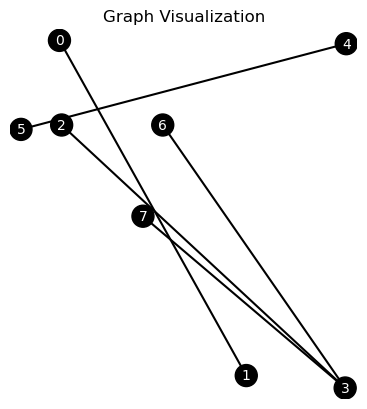

In [37]:
#GRAPHEN PLOTTEN

%matplotlib inline
import matplotlib.pyplot as plt

plot_graph(graphe)